In [9]:
from utils import *
from envs import *
from model import *
import numpy as np
from copy import deepcopy
import argparse
import pandas as pd

parser = argparse.ArgumentParser()
parser.add_argument('--episodes', type=int, required=False, help='episodes', default=1)
parser.add_argument('--tmax', type=int, required=False, help='tmax', default=100)

parser.add_argument('--goalcoords', type=float,nargs='+', required=False, help='goalcoords', default=[0.5])
parser.add_argument('--rsz', type=float, required=False, help='rsz', default=0.05)
parser.add_argument('--rmax', type=int, required=False, help='rmax', default=5)

parser.add_argument('--seed', type=int, required=False, help='seed', default=2020)
parser.add_argument('--pcinit', type=str, required=False, help='pcinit', default='uni')
parser.add_argument('--npc', type=int, required=False, help='npc', default=32)
parser.add_argument('--alpha', type=float, required=False, help='alpha', default=1.0)
parser.add_argument('--sigma', type=float, required=False, help='sigma', default=0.05)

parser.add_argument('--plr', type=float, required=False, help='plr', default=0.01)
parser.add_argument('--clr', type=float, required=False, help='clr', default=0.01)
parser.add_argument('--llr', type=float, required=False, help='llr', default=0.000) 
parser.add_argument('--alr', type=float, required=False, help='alr', default=0.000) 
parser.add_argument('--slr', type=float, required=False, help='slr', default=0.000)
parser.add_argument('--gamma', type=float, required=False, help='gamma', default=0.9)
parser.add_argument('--nact', type=int, required=False, help='nact', default=2)

parser.add_argument('--balpha', type=float, required=False, help='balpha', default=0.0)
parser.add_argument('--paramsindex', type=int,nargs='+', required=False, help='paramsindex', default=[0,1,2])
parser.add_argument('--noise', type=float, required=False, help='noise', default=0.000)

parser.add_argument('--datadir', type=str, required=False, help='datadir', default='./data/')
parser.add_argument('--figdir', type=str, required=False, help='figdir', default='./fig/')
parser.add_argument('--csvname', type=str, required=False, help='csvname', default='results')
args, unknown = parser.parse_known_args()


# training params
train_episodes = args.episodes
tmax = args.tmax

# env pararms
envsize = 1
maxspeed = 0.1
goalsize = args.rsz
startcoord = [-0.75]
goalcoords = args.goalcoords
seed = args.seed
initvelocity = 0.0
max_reward = args.rmax

#agent params
npc = args.npc
sigma = args.sigma
alpha = args.alpha
nact = args.nact

# noise params
noise = args.noise
paramsindex = args.paramsindex
piname = ''.join(map(str, paramsindex))
pcinit = args.pcinit

actor_eta = args.plr
critic_eta = args.clr
pc_eta = args.llr
sigma_eta = args.slr
constant_eta = args.alr
etas = [pc_eta, sigma_eta,constant_eta, actor_eta,critic_eta]
gamma = args.gamma
balpha = args.balpha

In [16]:
import ast

# Load the CSV file with proper error handling
csv_file_path = './csvs/results_npc.csv'
df = pd.read_csv(csv_file_path)

# Ensure all necessary columns are of the correct type
df['npc'] = df['npc'].astype(int)
df['seed'] = df['seed'].astype(int)

# Parameters
train_episodes = 50000
npcs = [4,8,16,32,64,128,256,512,1024]
seed_count = 10  # Specify the number of seeds to use

trial_len = 100  # Looks like you're trying to match this to the number of trials

# Initialize matrices to store scores and drifts
dxrs = np.zeros([len(npcs), seed_count, trial_len])

# Function to convert a string representation of array back to numpy array
def str_to_array(arr_str):
    # Ensure removal of newline characters and proper formatting of the string
    cleaned_str = arr_str.replace("\n", " ").replace('[ ', '[').replace(' ]', ']').replace('[', '').replace(']', '')
    # Ensure single spaces are replaced with a single comma
    cleaned_str = ','.join(cleaned_str.split())
    return np.array(ast.literal_eval(f"[{cleaned_str}]"))

# Fill the matrices with values from the CSV file
for i, row in df.iterrows():
    npc = row['npc']
    seed = row['seed']
    dxr_values = str_to_array(row['dxr'])

    if npc in npcs and seed < seed_count:
        npc_idx = npcs.index(npc)
        dxrs[npc_idx, seed] = dxr_values

print(dxrs.shape)

(9, 10, 100)


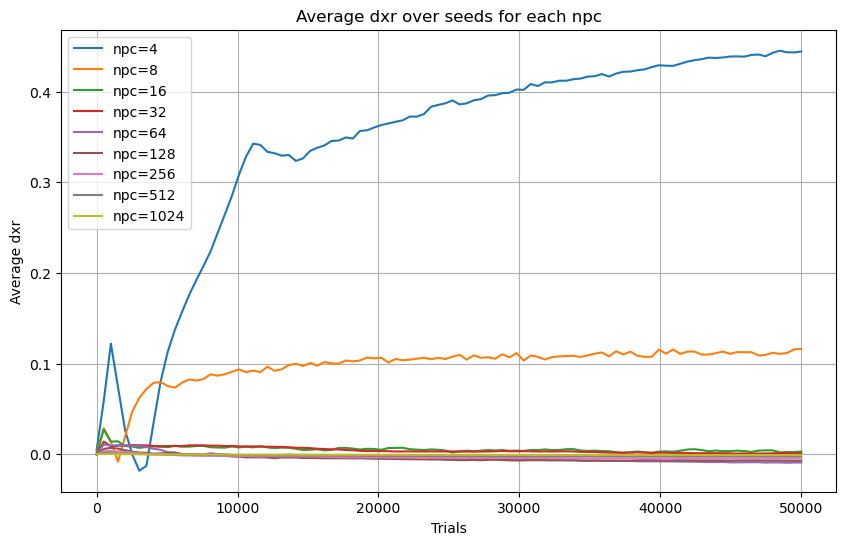

In [17]:

# Calculate the average dxr over all seeds for each npc
average_dxrs = np.mean(dxrs, axis=1)

# Plotting
plt.figure(figsize=(4, 3))
for idx, npc in enumerate(npcs):
    plt.plot(np.linspace(0, train_episodes, trial_len), average_dxrs[idx], label=f'npc={npc}')

plt.xlabel('Trials')
plt.ylabel('Average dxr')
plt.legend()
plt.title('Average dxr over seeds for each npc')
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


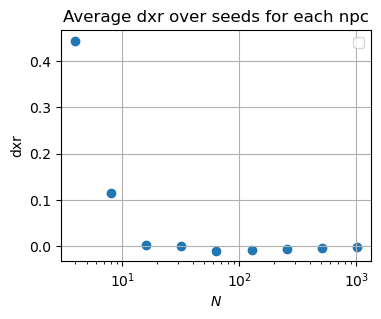

In [19]:

# Calculate the average dxr over all seeds for each npc
last_dxrs = average_dxrs[:,-1]

# Plotting
plt.figure(figsize=(4, 3))
plt.scatter(npcs, last_dxrs)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$N$')
plt.ylabel('dxr')
plt.legend()
plt.title('Average dxr over seeds for each npc')
plt.grid(True)
plt.show()